## LiNGAMで成功・失敗のパスを考えてみる

In [79]:
%pip install gcastle pandas numpy matplotlib networkx


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [80]:
import pandas as pd
import japanize_matplotlib  # noqa: F401, WPS433
df = pd.read_csv("../df_check_99.csv")
df.columns

Index(['Unnamed: 0', 'file', 'country', 'eval_year', 'evaluator_group',
       'evaluator', 'project_cost_plan', 'project_cost_act', 'プロジェクト期間開始_計画時',
       'プロジェクト期間終了_計画時', 'プロジェクト期間開始_実績', 'プロジェクト期間終了_実績',
       'project_duration_plan', 'project_duration_act', '妥当性評価', '整合性評価',
       '有効性評価', 'インパクト評価', '効率性評価', '効率性_コスト', '効率性_期間', '持続性評価', '適応・貢献評価',
       '付加価値・創造価値評価', '総合評価', '備考', 'type', '分野', '案件名', '連番', 'region',
       'region_detail', 'alpha2', 'alpha3', 'project_start_year',
       'project_end_year', 'join_flg', 'control_of_corruption',
       'government_effectiveness', 'political_stability', 'regulatory_quality',
       'rule_of_law', 'voice_and_accountability', 'freedom_house_score',
       'gdp_growth', 'Year', 'population', 'external_eval_flg', 'その他_flg_fix',
       'インフラ_flg_fix', 'エネルギー一般_flg_fix', '人材・教育_flg_fix', '保健・社会福祉_flg_fix',
       '公益事業一般_flg_fix', '商業経営_flg_fix', '工業_flg_fix', '放送_flg_fix',
       '林業・森林保全_flg_fix', '水産_flg_fix', '水資源開発_flg_fix', 

In [81]:
cols = [
    'political_stability',  # 最上流：国の安定度（これが低いと全てが狂うはず）
    'project_cost_plan',    # 最上流：プロジェクトのデカさ
    #'duration_rate',        # 中間：遅延したか
    'cost_rate',            # 中間：金がかかりすぎたか
    'total_eval'            # 最下流：最終的な成績
]
df = df[cols].dropna().reset_index(drop=True)

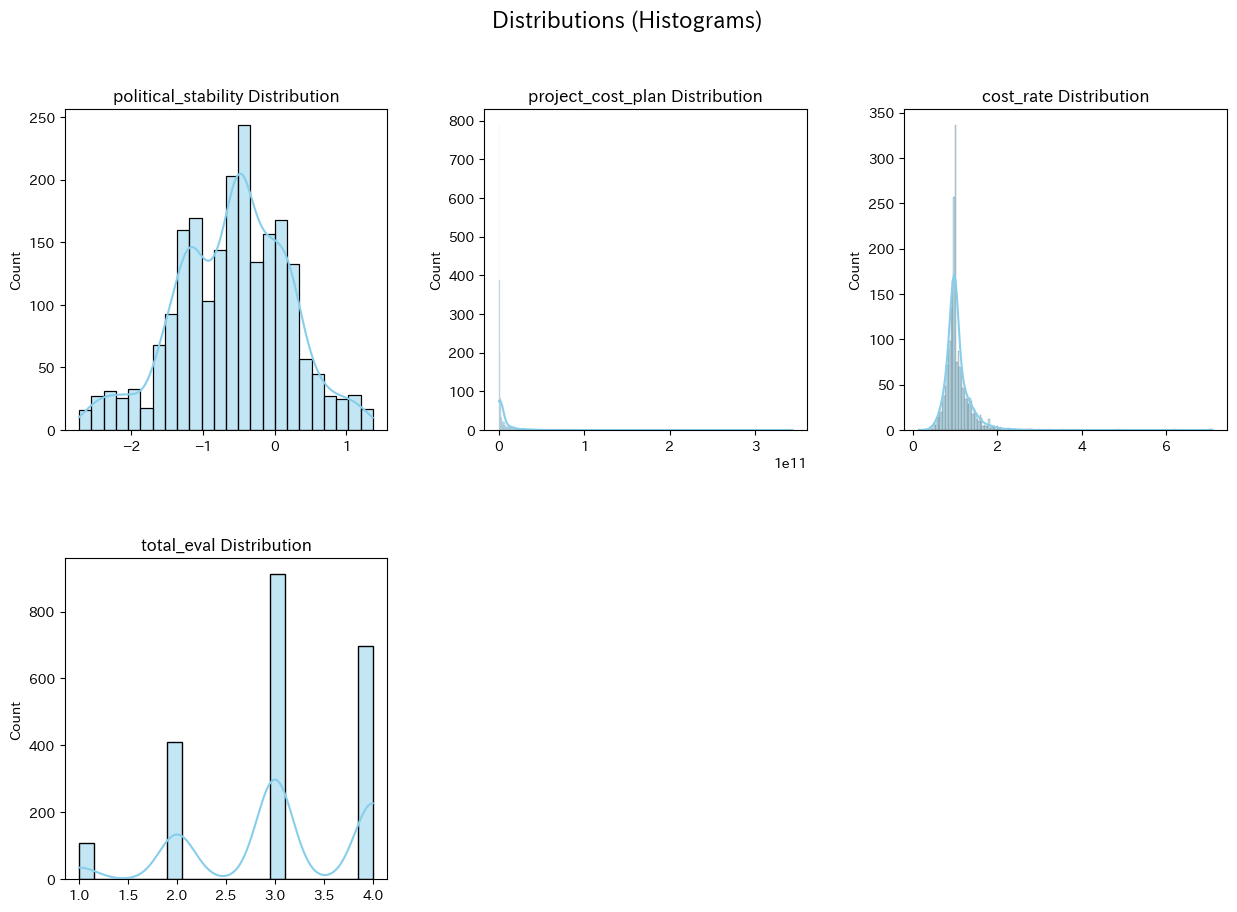

Column                    | Shapiro p-value | Skewness (歪度)   | Kurtosis (尖度)   | 判定
-------------------------------------------------------------------------------------
political_stability       | 1.92e-09        | -0.2149          | -0.0168          | ◎ (非ガウス)
project_cost_plan         | 7.82e-67        | 9.7096          | 141.7851          | ◎ (非ガウス)
cost_rate                 | 2.84e-56        | 6.8915          | 90.5400          | ◎ (非ガウス)
total_eval                | 5.86e-42        | -0.5583          | -0.3664          | ◎ (非ガウス)
-------------------------------------------------------------------------------------
※ p-value < 0.05 なら「正規分布ではない」ため、LiNGAMの前提条件をクリアしています。


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# ---------------------------------------------------------
# 2. 視覚的確認（ヒストグラム + QQプロット）
# ---------------------------------------------------------
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, col in enumerate(cols):
    # ヒストグラムとカーネル密度推定(KDE)
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True, ax=ax, color='skyblue')
    ax.set_title(f'{col} Distribution')
    ax.set_xlabel('')
    
    # 正規分布の理論線（赤）と比較
    mu, std = stats.norm.fit(df[col].dropna())
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    # 頻度に合わせるためのスケーリング（簡易的）
    # ※ seabornのhistplotはdensity=Falseがデフォなので、
    # 形状比較のためにここではKDEの形状(青線)と、もし正規分布だったら(想像上の形)を脳内で比較するだけで十分
    
plt.suptitle("Distributions (Histograms)", fontsize=16)
plt.show()

# ---------------------------------------------------------
# 3. 統計的検定（Shapiro-Wilk検定 / Jarque-Bera検定）
# ---------------------------------------------------------
print(f"{'Column':<25} | {'Shapiro p-value':<15} | {'Skewness (歪度)':<15} | {'Kurtosis (尖度)':<15} | {'判定'}")
print("-" * 85)

for col in cols:
    # 欠損値除去
    clean_data = df[col].dropna()
    
    # 1. Shapiro-Wilk検定 (正規性の検定)
    # Nが大きいと鋭敏すぎるため、p値は参考程度だが、0.00なら確実に非正規
    stat, p_shapiro = stats.shapiro(clean_data)
    
    # 2. 歪度（Skewness）: 0なら対称。絶対値が大きいほど歪んでいる
    skew = stats.skew(clean_data)
    
    # 3. 尖度（Kurtosis）: 0なら正規分布並み。大きいほど裾が厚い（LiNGAM向き）
    kurt = stats.kurtosis(clean_data)
    
    # 判定（p値が0.05未満なら「正規分布ではない」＝ LiNGAMには好都合）
    is_non_gaussian = "◎ (非ガウス)" if p_shapiro < 0.05 else "△ (正規分布の疑い)"
    
    print(f"{col:<25} | {p_shapiro:.2e}        | {skew:.4f}          | {kurt:.4f}          | {is_non_gaussian}")

print("-" * 85)
print("※ p-value < 0.05 なら「正規分布ではない」ため、LiNGAMの前提条件をクリアしています。")

In [83]:
from sklearn.preprocessing import StandardScaler

# 1. データの標準化（必須！）
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols)

"""
# 2. 事前知識（Prior Knowledge）の入力（任意だが推奨）
# 時間的に「ありえない矢印」を禁止する行列を作る
prior_knowledge = np.full((len(cols), len(cols)), -1) # -1は「探索対象」

# 列名のインデックスを取得
idx_plan_cost = cols.index('project_cost_plan')
idx_plan_dur = cols.index('project_duration_plan')
idx_eval = cols.index('total_eval')

# 【禁止ルール】結果（評価）が原因（計画）に向かうことはない
prior_knowledge[idx_plan_cost, idx_eval] = 0 # 0は「矢印なし（禁止）」
prior_knowledge[idx_plan_dur, idx_eval] = 0
"""

# グラフ描画部分は同じ...

"\n# 2. 事前知識（Prior Knowledge）の入力（任意だが推奨）\n# 時間的に「ありえない矢印」を禁止する行列を作る\nprior_knowledge = np.full((len(cols), len(cols)), -1) # -1は「探索対象」\n\n# 列名のインデックスを取得\nidx_plan_cost = cols.index('project_cost_plan')\nidx_plan_dur = cols.index('project_duration_plan')\nidx_eval = cols.index('total_eval')\n\n# 【禁止ルール】結果（評価）が原因（計画）に向かうことはない\nprior_knowledge[idx_plan_cost, idx_eval] = 0 # 0は「矢印なし（禁止）」\nprior_knowledge[idx_plan_dur, idx_eval] = 0\n"

In [85]:
# ---------------------------------------------------------
# 相関の確認（まずは事実確認）
# ---------------------------------------------------------
corr_val = df['duration_rate'].corr(df['cost_rate'])
print(f"工期とコストの相関係数: {corr_val:.3f}")
# これが 0.5 ~ 0.8 くらいあれば「強い関係」がある証拠


KeyError: 'duration_rate'

In [ ]:

# ---------------------------------------------------------
# 事前知識で「順序」を固定する
# ---------------------------------------------------------
# indexの確認（そちらの環境に合わせて修正してくれ）
# 例: [0:政情, 1:計画予算, 2:duration_rate, 3:cost_rate, 4:total_eval]
idx_dur = cols.index('duration_rate')
idx_cost = cols.index('cost_rate')

# 事前知識行列の初期化（-1: 探索する）
prior_knowledge = np.full((len(cols), len(cols)), -1)

# 【強制ルール】
# 1. 「工期遅延(2)」は「コスト超過(3)」の原因である（逆はなし）
prior_knowledge[idx_dur, idx_cost] = 1   # 1は「必ず矢印を引く（強制）」
prior_knowledge[idx_cost, idx_dur] = 0   # 0は「矢印なし（禁止）」

# 2. ついでに「結果(4)」への逆流も禁止しておく
idx_eval = cols.index('total_eval')
prior_knowledge[idx_eval, :] = 0         # 評価は誰の原因にもならない

# ---------------------------------------------------------
# 再実行 (DirectLiNGAM または ICALiNGAM)
# ---------------------------------------------------------
# 強制ルールがある場合は DirectLiNGAM の方が素直に動くことが多い
model = DirectLiNGAM(prior_knowledge=prior_knowledge)
model.learn(df_scaled)

print("--- 係数行列 ---")
print(pd.DataFrame(model.causal_matrix, index=cols, columns=cols))

学習完了。

--- 隣接行列 (因果係数) ---
                     political_stability  project_cost_plan  cost_rate  \
political_stability                    0                  0          0   
project_cost_plan                      0                  0          0   
cost_rate                              0                  0          0   
total_eval                             0                  0          0   

                     total_eval  
political_stability           0  
project_cost_plan             0  
cost_rate                     0  
total_eval                    0  


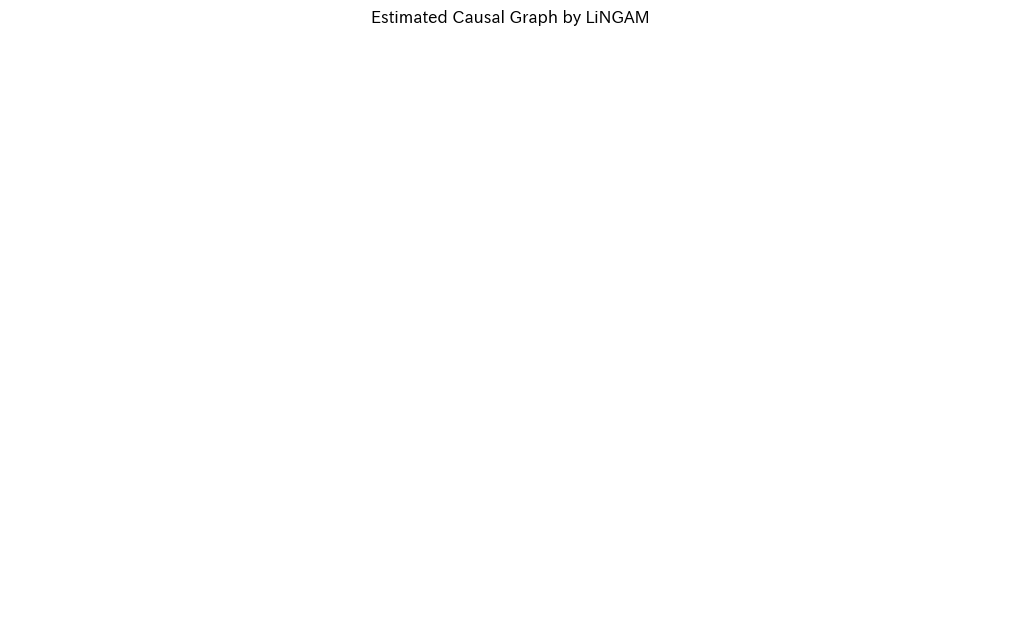

In [ ]:

# 1. 必要なライブラリのインストール（未インストールの場合）


import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# gCastleのDirectLiNGAM（通常のLiNGAMより安定性が高いアルゴリズム）を使用
from castle.algorithms import DirectLiNGAM
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

# ---------------------------------------------------------
# 2. データの準備
# ---------------------------------------------------------
# 実際のCSVファイルを読み込む場合はこちら
#df = pd.read_csv("../df_check_99.csv")

# データフレーム化
# ---------------------------------------------------------
# 3. LiNGAMの実行
# ---------------------------------------------------------
# アルゴリズムの初期化と学習
# model = DirectLiNGAM()
# model.learn(df_scaled)

# ---------------------------------------------------------
# 4. 結果の出力
# ---------------------------------------------------------
print("学習完了。")

#隣接行列（Adjacency Matrix）の取得
# 行(Row)から列(Col)への因果の強さを表す
adj_matrix = model.causal_matrix
print("\n--- 隣接行列 (因果係数) ---")
print(pd.DataFrame(adj_matrix, index=df_scaled.columns, columns=df_scaled.columns))

# ---------------------------------------------------------
# 5. 因果グラフの可視化
# ---------------------------------------------------------
# 行列をグラフ描画用に変換
G = nx.DiGraph()
labels = list(df.columns)

# 係数が小さいノイズ（閾値以下）をカットしてエッジを追加
threshold = 0.0
for i in range(len(labels)):
    for j in range(len(labels)):
        weight = adj_matrix[i, j]
        if abs(weight) > threshold:
            # i (原因) -> j (結果)
            G.add_edge(labels[i], labels[j], weight=round(weight, 2))

# 描画
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=1.0) # ノードの配置アルゴリズム
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=10, font_weight='bold', 
        arrowsize=20, edge_color='gray')

# エッジの上に係数（重み）を表示
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Estimated Causal Graph by LiNGAM")
plt.show()

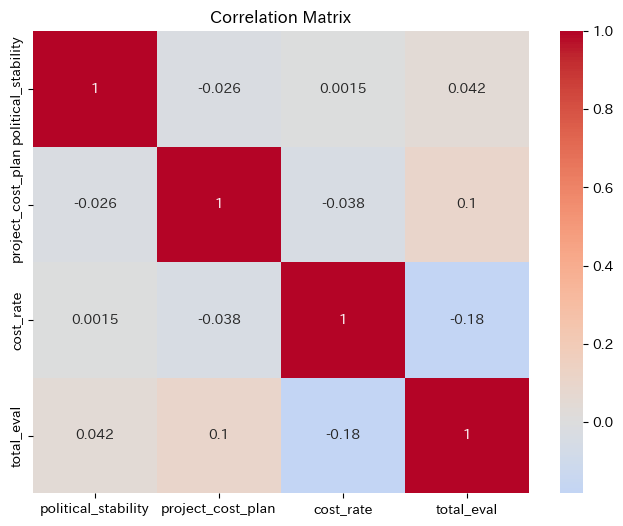

                     political_stability  project_cost_plan  cost_rate  \
political_stability             1.000000          -0.025506   0.001451   
project_cost_plan              -0.025506           1.000000  -0.037656   
cost_rate                       0.001451          -0.037656   1.000000   
total_eval                      0.042288           0.101321  -0.183300   

                     total_eval  
political_stability    0.042288  
project_cost_plan      0.101321  
cost_rate             -0.183300  
total_eval             1.000000  


In [ ]:
import seaborn as sns

# 相関行列をヒートマップで表示
plt.figure(figsize=(8, 6))
sns.heatmap(df_clean[cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

# 数値でも確認
print(df_clean[cols].corr())

In [86]:
df_scaled

,political_stability,project_cost_plan,cost_rate,total_eval
0,-0.787025,-0.269573,-0.369421,1.138286
1,1.140522,-0.208151,-0.183658,-0.039901
2,0.108830,-0.232739,-0.249836,1.138286
3,1.124538,-0.205856,-0.155796,1.138286
4,0.794797,0.038278,-0.236184,-0.039901
...,...,...,...,...
2121,1.715043,-0.308417,-1.071578,-0.039901
2122,0.272183,-0.308417,-0.088068,1.138286
2123,0.313926,-0.313717,-0.219839,1.138286
2124,-1.771988,-0.319345,0.066868,-1.218088


In [ ]:
from castle.algorithms import PC

# PCアルゴリズムで骨格（Skeleton）を見つける
pc = PC()
pc.learn(df_scaled)

# 結果表示
print(pc.causal_matrix)

[[0 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 0]]
